In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter, FFMpegWriter
temp_bg = 32.123
plt.rcParams['animation.ffmpeg_path'] = r'C:\Program Files\FFMpeg\bin' # make sure to change this to wherever your FFMpeg is located

# part 1 - fire

## Functions

In [2]:
def temp_curve(temp_0, tpeak, burn_time):
    """ Returns the temperature evolution curve for all time, needs params to control peak temp and how long it burns for """
    time = np.linspace(0,1000,N_frames)

    B = burn_time
    A = - B**2 / 4 / (tpeak - temp_0)
    
    y = A*time**2 + B*time + temp_0
    y[y<temp_bg] = temp_bg
    
    return y

# note for future: improve the fire simulation algo

def temp_evolution(time, temp_0, tpeak, burn_time):
    """ Increments timestep from time = 0 by time """
    temp_ls = temp_curve(temp_0, tpeak, burn_time)
#     print(temp_ls[time])
    return temp_ls[time]

# at every timestep, check the array for temp values. make it a binomial process with chance to spread proportional to T of a location

def spread_fire(temp_self, k, coords):
    """ Given a temp_self, determines probability of spreading and spreads the fire to other grids """
    prob_spread = k * min((temp_self - temp_bg)/600,1)
    x_coord, y_coord = coords
    for i in [-1,0,1]:
        for j in [-1,0,1]:
            if i==0 and j==0: continue
            if x_coord+i<0 or y_coord+j< 0: continue
            if np.random.rand() < prob_spread:
                try:
                    if check_grid[x_coord+i, y_coord+j]==0:
                        temp_grid[x_coord+i, y_coord+j] = np.random.normal(450,50)
                        check_grid[x_coord+i, y_coord+j]=1
                except IndexError: pass
            
    return temp_grid

## Make values

In [13]:
# initialise vals
temp_grid = np.full((100,100),temp_bg)
bmass_grid = np.random.uniform(0,1,(100,100))
check_grid = np.zeros((100,100))
N_frames = 201

temp_grid[50,50] = 500 # seed with fire, temperature = 500 celsius

frames = [] # make frames for the gif
firefrac_frames = [] # list of fire frac for each frame

for _ in range(N_frames):
    old_temp_grid = np.copy(temp_grid)
    for coord, item in np.ndenumerate(old_temp_grid):
#         print(item, coord)
        k = bmass_grid[coord]
        temp_grid = spread_fire(item, k, coord)
        if check_grid[coord]!=0:
            temp_grid[coord] = temp_evolution(int(check_grid[coord]-1), 500, 1100, 8)
            check_grid[coord]+=1
    firefrac_frames.append(np.sum(check_grid!=0)/np.size(check_grid))
    frames.append(temp_grid.copy()+273) # convert to Kelvins

## Plotting

<IPython.core.display.Javascript object>


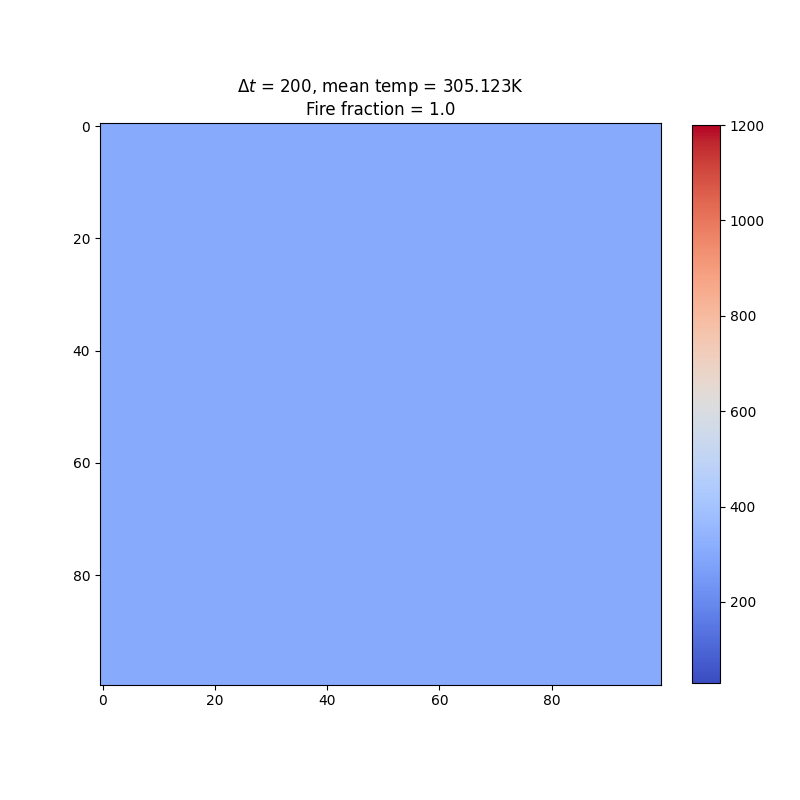

In [23]:
%matplotlib notebook

fig,ax = plt.subplots(figsize=(8,8))

im = plt.imshow(frames[0], cmap = 'coolwarm', vmin = 30, vmax = 1200)

fig.colorbar(im, ax= ax, fraction=.045)

# animation function.  This is called sequentially
def animate(i):
    plt.title(f'$\\Delta t$ = {i}, mean temp = {round(np.mean(frames[i]),5)}K\nFire fraction = {firefrac_frames[i]}')
    im.set_array(frames[i])
    return [im]


anim = FuncAnimation(fig, animate, frames=N_frames, repeat=False)

In [24]:
anim.save('fire_spread3.gif', writer=PillowWriter(fps=10), dpi=200)

# part 2 - light

In [6]:
from hotstuff import *

## Functions

In [60]:
def modis4_detect(T4, T11):
    """ If the temperature detected by satellite exceeds 310K. """
    if T11>360: return True
    elif T4>310 and T4-T11>10: return True
    else: return False

## Make values

In [28]:
detected_list = []
for temp_arr in frames:
    detected_list.append(totalfinder(temp_arr))

detected_list = np.array(detected_list)

fire_list = np.transpose([detected_list[:,0]>400,detected_list[:,1]>700])
fire_list_10 = np.transpose([detected_list[:,0]>40,detected_list[:,1]>70])
fire_list_50 = np.transpose([detected_list[:,0]>40,detected_list[:,1]>70])
fire_list_modis = np.vectorize(modis4_detect)(detected_list[:,0], detected_list[:,1])

## Plotting

<IPython.core.display.Javascript object>


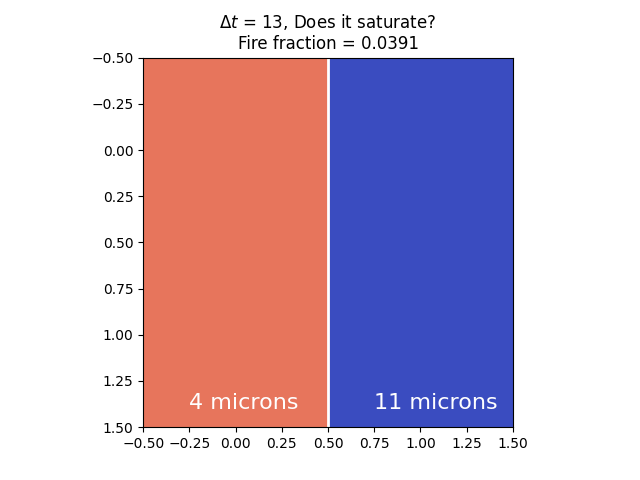

In [22]:
%matplotlib notebook

fire_detected = [[1000,1000],[1000,1000]]

detector_fig = plt.figure()

im_detector = plt.imshow(fire_detected, cmap = 'coolwarm', vmin = 30, vmax = 1200)
plt.vlines(0.5,-0.5,1.5,color='white',linewidth=2)
plt.text(-0.25,1.4,'4 microns',fontsize=16,c='white')
plt.text(.75,1.4,'11 microns',fontsize=16,c='white')

def animate_saturator(i):
    plt.title(f'$\\Delta t$ = {i}, Does it saturate?\nFire fraction = {firefrac_frames[i]}')
    im_detector.set_array((-1+2*fire_list[i,:])*fire_detected)
    
    return [im_detector]

anim_saturator = FuncAnimation(detector_fig, animate_saturator, frames=N_frames, repeat=False)

In [18]:
# ffwrite = FFMpegWriter(fps=10, extra_args = ['-vcodec', 'libx264'])
anim_saturator.save('fire_detected3.gif', writer=PillowWriter(fps=10), dpi=200)

## 10 percent and 50 percent saturation plot

<IPython.core.display.Javascript object>


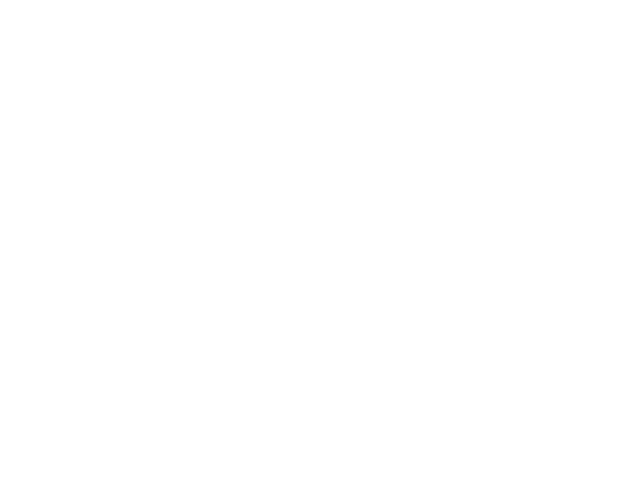

C:\Users\hills\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\animation.py:889: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


In [19]:
%matplotlib notebook

fire_detected = [[1000,1000],[1000,1000]]

detector_fig_10 = plt.figure()

im_detector = plt.imshow(fire_detected, cmap = 'coolwarm', vmin = 30, vmax = 1200)
plt.vlines(0.5,-0.5,1.5,color='white',linewidth=2)
plt.text(-0.25,1.4,'4 microns',fontsize=16,c='white')
plt.text(.75,1.4,'11 microns',fontsize=16,c='white')

def animate_saturator(i):
    plt.title(f'$\\Delta t$ = {i}, Does it saturate?\nFire fraction = {firefrac_frames[i]}')
    im_detector.set_array((-1+2*fire_list_10[i,:])*fire_detected)
    
    return [im_detector]

anim_10_percent = FuncAnimation(detector_fig_10, animate_saturator, frames=N_frames, repeat=False)
# anim_10_percent.save('fire_detected_10.gif', writer=PillowWriter(fps=10), dpi=200)

<IPython.core.display.Javascript object>


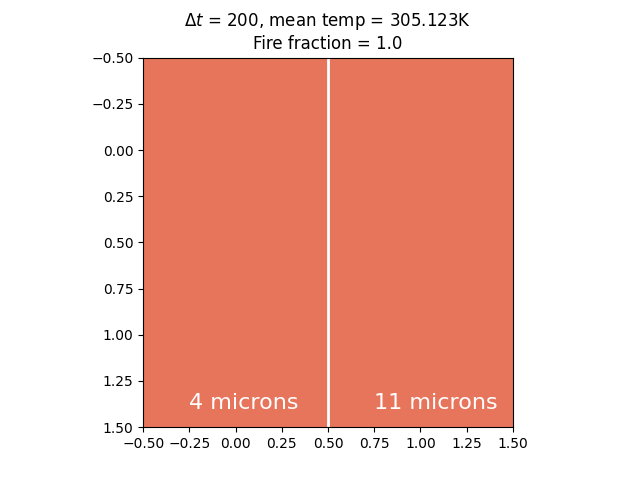

In [20]:
%matplotlib notebook

fire_detected = [[1000,1000],[1000,1000]]

detector_fig_50 = plt.figure()

im_detector = plt.imshow(fire_detected, cmap = 'coolwarm', vmin = 30, vmax = 1200)
plt.vlines(0.5,-0.5,1.5,color='white',linewidth=2)
plt.text(-0.25,1.4,'4 microns',fontsize=16,c='white')
plt.text(.75,1.4,'11 microns',fontsize=16,c='white')

def animate_saturator(i):
    plt.title(f'$\\Delta t$ = {i}, Does it saturate?\nFire fraction = {firefrac_frames[i]}')
    im_detector.set_array((-1+2*fire_list_50[i,:])*fire_detected)
    
    return [im_detector]

anim_50_percent = FuncAnimation(detector_fig_50, animate_saturator, frames=N_frames, repeat=False)
# anim_50_percent.save('fire_detected_50.gif', writer=PillowWriter(fps=10), dpi=200)

## MODIS V4 detection plot

<IPython.core.display.Javascript object>


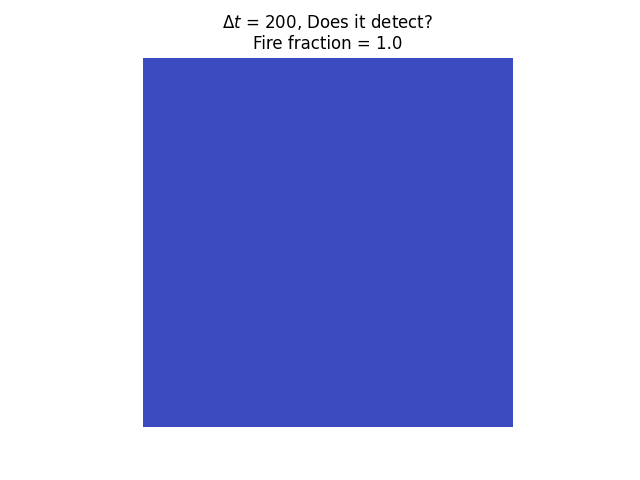

In [90]:
%matplotlib notebook

fire_list_modis = fire_list_modis.copy().astype(int)

fire_detected = np.array([[1,1],[1,1]])

detector_fig = plt.figure()
plt.axis('off')

im_detector = plt.imshow(fire_list_modis[0]*fire_detected, cmap = 'coolwarm',vmin=-1,vmax=1.5)

def animate_saturator(i):
    plt.title(f'$\\Delta t$ = {i}, Does it detect?\nFire fraction = {firefrac_frames[i]}')
    im_detector.set_array(-1+2*fire_list_modis[i]*fire_detected)
    return [im_detector]

anim_modis = FuncAnimation(detector_fig, animate_saturator, frames=N_frames, repeat=False)

In [91]:
anim_modis.save('fire_detected_modis.gif', writer=PillowWriter(fps=10), dpi=200)